In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
#Just to push

In [2]:
def drawLines(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    edges = cv2.Canny(gray, 90, 100, apertureSize=3) 
    lines = cv2.HoughLinesP(
                    edges, #described above
                    1, #1 pixel resolution parameter
                    np.pi/180, # 1 degree resolution parameter
                    10, #min number of intersections/votes
                    minLineLength=10,
                    maxLineGap=60,
            ) # detect lines
    try:
        for line in lines:
            x1, y1, x2, y2 = line[0]
            cv2.line(img, (x1, y1), (x2, y2), (0, 255, 0), 2)
            slope = (y2-y1)/(x2-x1)
            print(str(slope))
    except TypeError:
        pass
    
    return img


3.282758620689655
1.7355072463768115


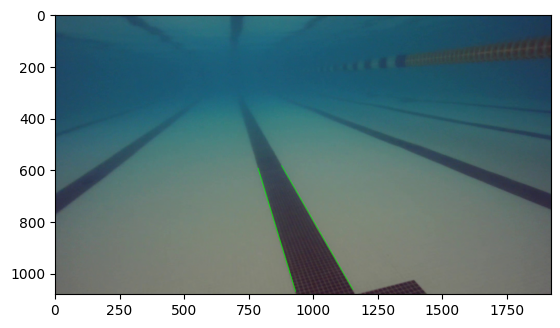

In [3]:
img = cv2.imread('rov_pool.jpg')

gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) # convert to grayscale
edges = cv2.Canny(gray, 106, 107, apertureSize=3) # detect edges, gray is image in grayscale, 50 and 150 represent 2 images that have been threshholded at 2 different levels, apertureSize controls how much light the image gets and how exposed it is
lines = cv2.HoughLinesP(
                edges, #described above
                1, #1 pixel resolution parameter
                np.pi/180, # 1 degree resolution parameter
                60, #min number of intersections/votes
                minLineLength=475,
                maxLineGap=100,
        ) # detect lines

for line in lines:
    x1, y1, x2, y2 = line[0]
    cv2.line(img, (x1, y1), (x2, y2), (0, 255, 0), 2)
    slope = (y2-y1)/(x2-x1)
    print(str(slope))

plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

In [ ]:
import cv2
import numpy as np

video = cv2.VideoCapture('AUV_Vid.mkv')

fps = int(video.get(cv2.CAP_PROP_FPS))
width = int(video.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(video.get(cv2.CAP_PROP_FRAME_HEIGHT))

output_file = 'output_video.avi'
fourcc = cv2.VideoWriter_fourcc(*'XVID')
output_video = cv2.VideoWriter(output_file, fourcc, 30, (width, height))

ret, frame = video.read()
count = 0
frequency = 1

while ret:
    if count % frequency == 0:
        processed_frame = drawLines(frame)
        output_video.write(processed_frame)

    count += 1
    ret, frame = video.read()

video.release()
output_video.release()

In [3]:
from dt_apriltags import Detector
import cv2
import numpy as np


cameraMatrix = np.array([ 1060.71, 0, 960, 0, 1060.71, 540, 0, 0, 1]).reshape((3,3))

camera_params = ( cameraMatrix[0,0], cameraMatrix[1,1], cameraMatrix[0,2], cameraMatrix[1,2] )


video = cv2.VideoCapture('AprilTagTest.mkv')

fps = int(video.get(cv2.CAP_PROP_FPS))
width = int(video.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(video.get(cv2.CAP_PROP_FRAME_HEIGHT))

output_file = 'output_video.avi'
fourcc = cv2.VideoWriter_fourcc(*'XVID')
output_video = cv2.VideoWriter(output_file, fourcc, 30, (width, height))

ret, frame = video.read()
count = 0
frequency = 1


while ret:
    if count % frequency == 0:
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        at_detector = Detector(families='tag36h11', #controls what it is supposed to detect
                       nthreads=1, #controls the number of threads used in the detection
                       quad_decimate=1.0, #controls to what scale the image is lowered in resolution
                       quad_sigma=0.0, #blur applied to the image to reduce noise
                       refine_edges=1, #attempts to redefine the edges of the tag boundaries
                       decode_sharpening=0.25, #controls how much the image is sharpened after the tags are discovered
                       debug=0) # no debugging information will be produced

        tags = at_detector.detect(frame, estimate_tag_pose=True, camera_params=camera_params, tag_size=0.1)

        color_frame = cv2.cvtColor(frame, cv2.COLOR_GRAY2RGB)

        for tag in tags:
            for idx in range(len(tag.corners)):
                cv2.line(color_frame, tuple(tag.corners[idx - 1, :].astype(int)), tuple(tag.corners[idx, :].astype(int)), (0, 255, 0))

            cv2.putText(color_frame, str(tag.tag_id),
                        org=(tag.corners[0, 0].astype(int) + 10, tag.corners[0, 1].astype(int) + 10),
                        fontFace=cv2.FONT_HERSHEY_SIMPLEX,
                        fontScale=0.8,
                        color=(0, 0, 255))
            print(tag.pose_t)
            print(tag.pose_R)

        output_video.write(color_frame)

    count += 1
    ret, frame = video.read()

video.release()
output_video.release()

[[ 0.06945575]
 [-0.11357916]
 [ 0.53989323]]
[[-0.04756652 -0.99737066  0.0546735 ]
 [ 0.99573468 -0.04301414  0.08162248]
 [-0.07905614  0.0583228   0.99516259]]
[[ 0.06940983]
 [-0.11348073]
 [ 0.53966214]]
[[-0.04719458 -0.99750341  0.05253208]
 [ 0.99570176 -0.04278335  0.08214376]
 [-0.07969118  0.05618303  0.99523504]]
[[ 0.06933421]
 [-0.11333941]
 [ 0.53940458]]
[[-0.04699719 -0.99752794  0.05224239]
 [ 0.99579995 -0.04267351  0.08100268]
 [-0.07857307  0.05582987  0.99534381]]
[[ 0.06919198]
 [-0.11316691]
 [ 0.53899644]]
[[-0.04635197 -0.99754994  0.05239859]
 [ 0.99570795 -0.04193253  0.08250664]
 [-0.08010729  0.05599804  0.99521206]]
[[ 0.069049  ]
 [-0.11290909]
 [ 0.53845404]]
[[-0.04592055 -0.99759453  0.05192743]
 [ 0.99573352 -0.04154609  0.08239346]
 [-0.08003789  0.05548944  0.99524613]]
[[ 0.06877281]
 [-0.11251118]
 [ 0.53786393]]
[[-0.04608692 -0.99750857  0.05341021]
 [ 0.99565991 -0.04154239  0.08328011]
 [-0.08085383  0.05701653  0.99509385]]
[[ 0.06843667]
 

Error, more than one new minimum found.


[[ 0.20295847]
 [-0.07031198]
 [ 0.48842255]]
[[ 0.13628472 -0.95926614  0.24745696]
 [ 0.99054366  0.13593242 -0.01859151]
 [-0.01580322  0.24765066  0.9687205 ]]
[[ 0.21062164]
 [-0.07083219]
 [ 0.49070664]]
[[ 0.17504329 -0.90630745  0.38466434]
 [ 0.98347164  0.14258093 -0.11159847]
 [ 0.04629673  0.39784103  0.91628551]]


Error, more than one new minimum found.


[[ 0.21533142]
 [-0.07067223]
 [ 0.48698162]]
[[ 0.21365414 -0.84662154  0.48742577]
 [ 0.97422938  0.14771904 -0.17045882]
 [ 0.07231204  0.51128374  0.85636436]]
[[ 0.21900588]
 [-0.07031939]
 [ 0.4838055 ]]
[[ 0.22180795 -0.82224011  0.52413972]
 [ 0.97361986  0.15724662 -0.16534169]
 [ 0.05353137  0.54698694  0.83542784]]
[[ 0.22210339]
 [-0.06986835]
 [ 0.48217692]]
[[ 0.23043951 -0.79939043  0.55486266]
 [ 0.9719735   0.16182319 -0.17053084]
 [ 0.04653108  0.57860884  0.81427677]]
[[ 0.22524971]
 [-0.06969784]
 [ 0.48078562]]
[[ 0.23663055 -0.79332822  0.56092452]
 [ 0.97101873  0.17313554 -0.1647626 ]
 [ 0.03359485  0.58365607  0.81130572]]
[[ 0.22768734]
 [-0.06950303]
 [ 0.47891802]]
[[ 0.24444566 -0.78378129  0.57090561]
 [ 0.96933753  0.18226649 -0.16481409]
 [ 0.02512124  0.59368832  0.80430287]]
[[ 0.22886703]
 [-0.06923287]
 [ 0.47744585]]
[[ 0.25622077 -0.77256751  0.5809392 ]
 [ 0.96598185  0.18284339 -0.18288617]
 [ 0.03507102  0.60803596  0.79313447]]
[[ 0.22961874]
 

Error, more than one new minimum found.


[[ 0.13487861]
 [-0.06071808]
 [ 0.53753103]]
[[-0.08344645 -0.98127346  0.17360614]
 [ 0.98798566 -0.10420848 -0.11412683]
 [ 0.13008086  0.1619969   0.97817993]]
[[ 0.12760964]
 [-0.06034767]
 [ 0.53916011]]
[[-0.10065894 -0.98720889  0.12363812]
 [ 0.98860744 -0.11322243 -0.09917665]
 [ 0.11190668  0.11224655  0.9873589 ]]
[[ 0.12019891]
 [-0.05996423]
 [ 0.5401609 ]]
[[-0.11452007 -0.99149343  0.06185419]
 [ 0.98775102 -0.12028832 -0.09939132]
 [ 0.10598618  0.04971424  0.99312407]]
[[ 0.11302779]
 [-0.05974892]
 [ 0.5414592 ]]
[[-0.12663073 -0.99123276  0.03771304]
 [ 0.98710256 -0.12967481 -0.09387743]
 [ 0.09794482  0.02533887  0.99486921]]
[[ 0.10613447]
 [-0.05956126]
 [ 0.54254936]]
[[-0.13667912 -0.99058132  0.00821324]
 [ 0.98626941 -0.13685059 -0.09243679]
 [ 0.09269014 -0.00453371  0.99568468]]
[[ 0.09907231]
 [-0.05955992]
 [ 0.54434968]]
[[-0.14650462 -0.98903282 -0.01872109]
 [ 0.98532655 -0.14422803 -0.09126815]
 [ 0.08756709 -0.03181759  0.99565036]]
[[ 0.09189767]
 

Error, more than one new minimum found.


[[-0.1611367 ]
 [-0.11322017]
 [ 1.21571316]]
[[-0.22632733 -0.96998627 -0.08889644]
 [ 0.97404662 -0.22509869 -0.02374367]
 [ 0.00302056 -0.09196312  0.99575783]]


Error, more than one new minimum found.


[[-0.16394487]
 [-0.11698011]
 [ 1.23250306]]
[[-0.22853306 -0.9684417  -0.09946517]
 [ 0.97351199 -0.22661175 -0.03035639]
 [ 0.00685841 -0.10376798  0.99457788]]


Error, more than one new minimum found.


[[-0.16715259]
 [-0.12076557]
 [ 1.24808144]]
[[-0.23235185 -0.96872433 -0.08709646]
 [ 0.97263068 -0.23155389 -0.01929643]
 [-0.0014746  -0.08919625  0.99601298]]
[[-0.16949388]
 [-0.1233272 ]
 [ 1.2550084 ]]
[[-0.23329114 -0.97086421 -0.05475337]
 [ 0.97014064 -0.23622019  0.05501961]
 [-0.06635042 -0.04028289  0.9969829 ]]
[[-0.1716125 ]
 [-0.12531165]
 [ 1.26537168]]
[[-0.23466198 -0.96968108 -0.06820824]
 [ 0.96940403 -0.23863989  0.05750505]
 [-0.07203876 -0.0526271   0.99601245]]
[[-0.1733594 ]
 [-0.12728196]
 [ 1.28086673]]
[[-0.23461878 -0.96798637 -0.08919871]
 [ 0.97022328 -0.23886096  0.04015259]
 [-0.06017325 -0.07712211  0.99520418]]
[[-0.17440742]
 [-0.12862117]
 [ 1.29137834]]
[[-0.23151373 -0.96878346 -0.08865661]
 [ 0.96848375 -0.23812638  0.07304143]
 [-0.09187281 -0.06895239  0.99338057]]
[[-0.17631234]
 [-0.1299789 ]
 [ 1.30696883]]
[[-0.22768775 -0.96783327 -0.10703764]
 [ 0.9695836  -0.235482    0.06675236]
 [-0.08981059 -0.08858325  0.99201163]]
[[-0.17758366]
 

Error, more than one new minimum found.


[[ 0.2032757 ]
 [-0.05269826]
 [ 1.36025514]]
[[-0.29338558 -0.9184127   0.26541102]
 [ 0.95395882 -0.29935891  0.01862293]
 [ 0.06234962  0.25865488  0.96395549]]
[[ 0.20765186]
 [-0.04262146]
 [ 1.33258667]]
[[-0.30180864 -0.91264917  0.2756502 ]
 [ 0.95304997 -0.29629529  0.06248884]
 [ 0.02464347  0.28156809  0.95922475]]
[[ 0.21250642]
 [-0.0332791 ]
 [ 1.31190436]]
[[-0.31615503 -0.93058353  0.1845543 ]
 [ 0.94729424 -0.29903886  0.11493208]
 [-0.05176499  0.21116359  0.97607906]]
[[ 0.21602853]
 [-0.02447704]
 [ 1.28782107]]
[[-0.32375823 -0.92525806  0.19768188]
 [ 0.94375666 -0.30099504  0.13684057]
 [-0.06711157  0.23086686  0.97066809]]
[[ 0.22054817]
 [-0.01615149]
 [ 1.26919781]]
[[-0.32405039 -0.92654194  0.1910795 ]
 [ 0.94222848 -0.29798113  0.15301219]
 [-0.08483413  0.22962421  0.96957511]]
[[ 0.22452106]
 [-0.00847637]
 [ 1.24543501]]
[[-0.32393153 -0.93951584  0.11125806]
 [ 0.93376866 -0.29858726  0.19728593]
 [-0.15213301  0.16779643  0.97401227]]
[[ 0.22802601]
 

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from dt_apriltags import Detector
import matplotlib.cm as cm
from lane_detection import *
from lane_following import *

video = cv2.VideoCapture('AUV_Vid.mkv')

width = int(video.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(video.get(cv2.CAP_PROP_FRAME_HEIGHT))

output_file = 'output_video_follow.avi'
fourcc = cv2.VideoWriter_fourcc(*'XVID')
output_video = cv2.VideoWriter(output_file, fourcc, 30, (width, height))

i = 0
ret = True
while ret:
    slopeSet = set() 
    i += 1
    ret, frame = video.read()
    if(i%1 == 0 and i > 90):
        lines = detect_lines(frame, 50, 90, 3,150,10)
        try:
            lanes = detect_lanes(lines)
            pickedLane = pick_lane(lanes)
            frame = draw_Single_lane(frame, pickedLane, (255, 0, 0))
            frame = draw_lines(frame, lines,(0, 255, 0))
            center_intercept, center_slope = get_lane_center(pickedLane)
            xPoint = pickedLane[0][2]
            yPoint = pickedLane[0][3]
            cv2.line(frame, (int(center_intercept), 1080), (int(xPoint), int(yPoint)), (0,0,255), 3)
        except:
            pass
        
    
        output_video.write(frame)



video.release()
output_video.release()